# BE - Machine Learning

<span style='color:skyblue'>

## 0. Chargement des librairies 

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

<span style='color:skyblue'>

## 1. Exploration des données 

<span style='color:skyblue'>

### 1.1 Extraction des données

</span>

Le dataset est un dataset UCML, on pourrait utiliser le module *ucmlrepo* et la methode *fetch_ucirepo* associée, mais le chargement des données est long (~2 minutes). On privilégiera donc un téléchargement et des méthodes de lecture manuelles, les données ne faisant que 600Ko

Le dataset a été construit pour prédire la target *income* qui comporte deux valeurs (>50K, <=50K) à partir de 14 features. Cette construction en "classes" nous impose de travailler avec des classifiers plutôt qu'avec des regressions.

In [79]:
names = pd.read_table("data/adult.names", sep=":", skiprows=96, header=None)[0].tolist()
names.append("income") # La target n'est pas dans le fichier des noms
adult = pd.read_csv("data/adult.data", sep=", ", names=names, engine='python', index_col=False) # Le engine permet juste d'éviter un warning

<span style='color:skyblue'>


### 1.2 Présentation des features
</span>

In [80]:
print("Nom des colonnes")
print(adult.columns.tolist())

print("\nNombre d'individus")
print(adult.shape[0])

Nom des colonnes
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

Nombre d'individus
32561


Le dataset contient différents types de features :

__Variables numériques continues :__

- __*age*__
- __*fnlwgt*__ : poids statistique attribué à chaque individu dans l'échantillon du recensement américain. Il permet d'estimer le nombre de personnes dans la population réelle représentée par cet individu du datset. Par exemple si *fnlwgt = 12000*, alors l'individu représente environ 12000 personnes dans la population totale du recensement (cf description officielle dans */data/adult.names*)

- __*capital-gain*__ : revenus supplémentaires
- __*capital-loss*__ : pertes de revenus
- __*hours-per-week*__ : nombre d'heures travaillées par semaine

__Variables numériques ordinales :__

- __*education-num*__ : nombre d'années d'éducation. --> version numérique ordinale de la feature *education*

__Variables catégorielles :__
- __*workclass*__ : type d'emploi
- __*martial-status*__ : statut marital
- __*occupation*__ : profession
- __*relationship*__ : rôle familial
- __*race*__ : race
- __*sex*__ : genre
- __*native-country*__ : pays d'origine
- __*education*__ : niveau d'éducation. --> valeurs textuelles associées à la feature *education-num*

__Variable binaire cible__ :
- __*income*__ : variable binaire pour indiquer si l'individu touche un salaire supérieur ou inférieur/égal à 50K 



<span style='color:skyblue'>

#### 1.2.1 Variables numériques

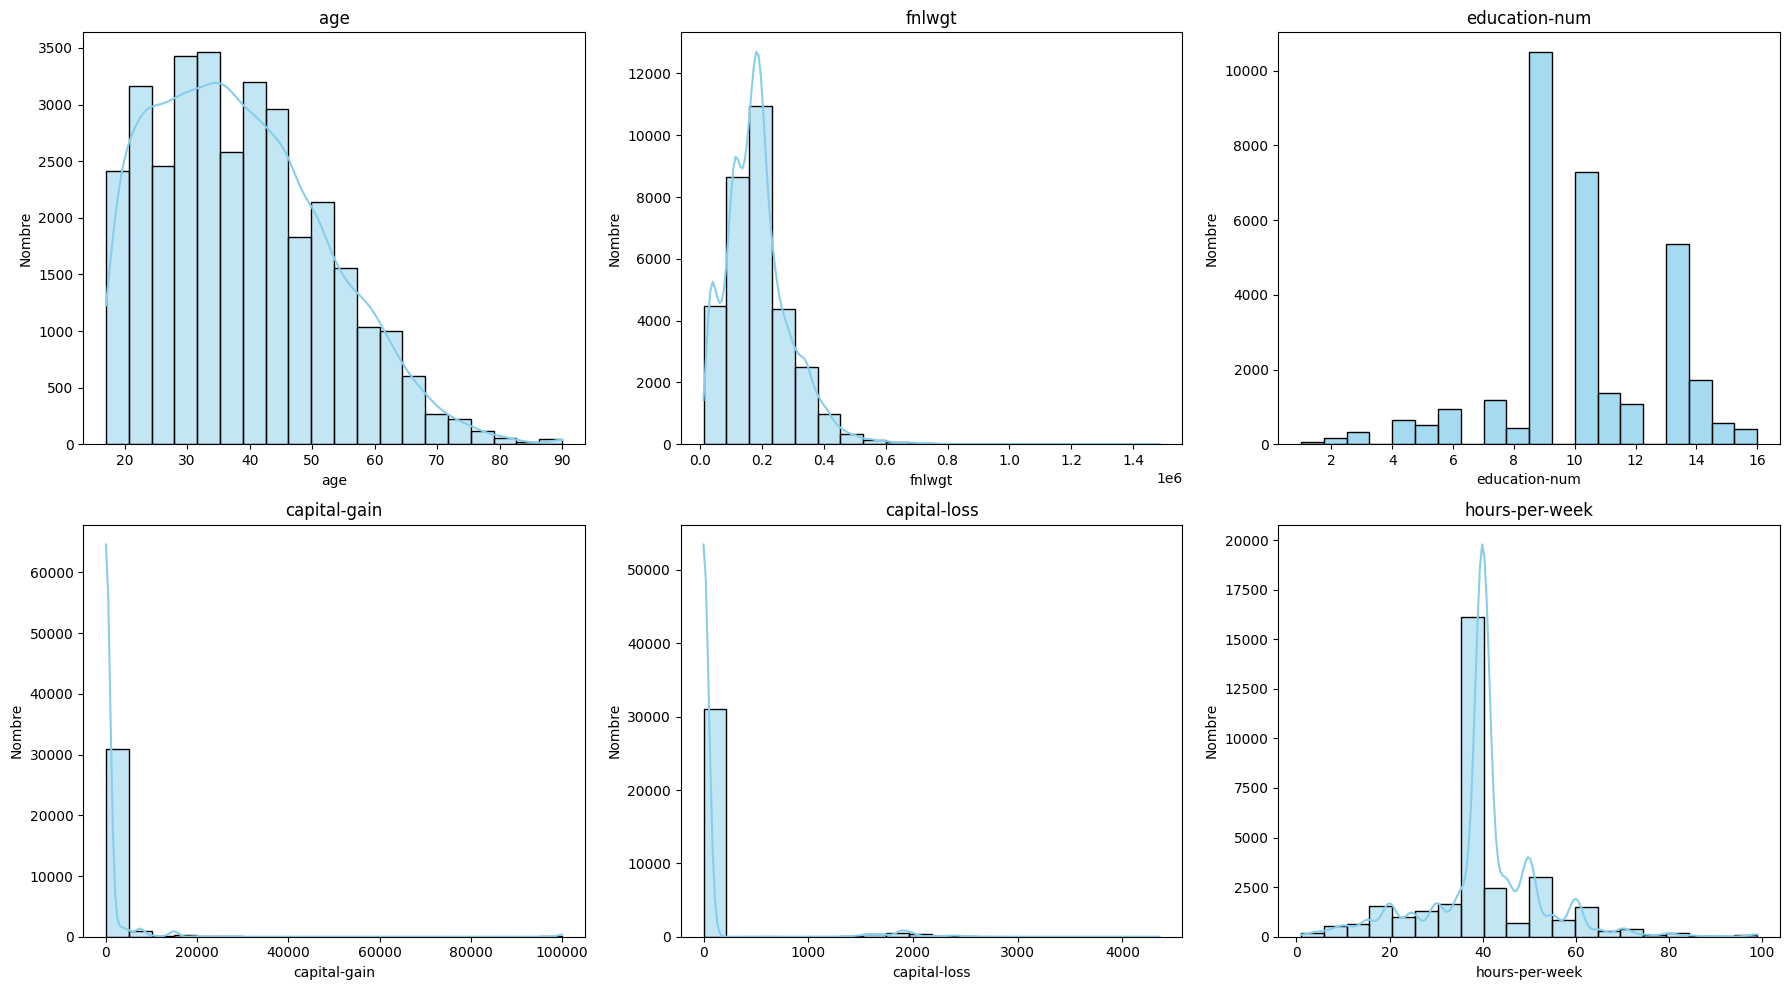

In [81]:
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  

for i, col in enumerate(numerical_features):
    if col=='education-num':
        #kde=False: pas d'estimation de la densité de proba. car la feature education-num n'est pas continue 
        sns.histplot(data=adult, x=col, bins=20, kde=False, ax=axes[i], color='skyblue') 
    else:
        #kde=True : estimation de la densité de probabilité continue 
        sns.histplot(data=adult, x=col, bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)       
    axes[i].set_ylabel("Nombre")   
plt.tight_layout()
plt.show()



Nous ne representons pas la densité de probabilité sur la feature __*education-num*__ car bien que cette variable soit numérique, elle n'est pas continue : les valeurs représentent ici des catégories de niveau d'études ordonnées.

<span style='color:skyblue'>

#### 1.2.2 Variables catégorielles 

Pour chacune des variables catégorielles du dataset, nous affichons la répartition des catégories à l’aide de barplots. Cela permet d’identifier des valeurs manquantes, des catégories peu fréquentes, ou d’éventuelles incohérences typographiques.

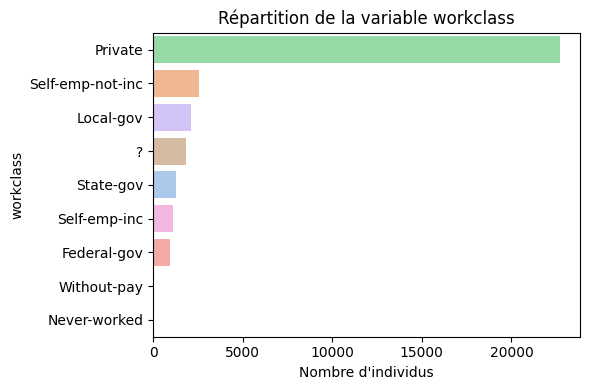

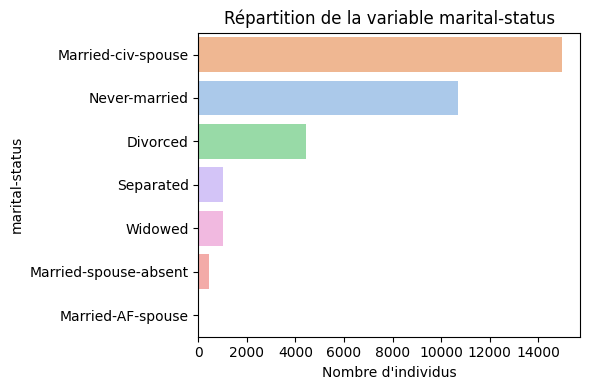

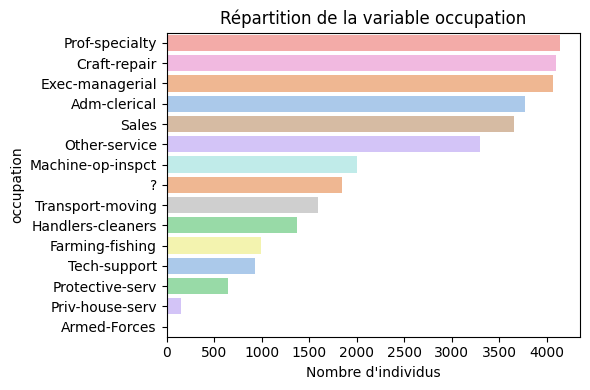

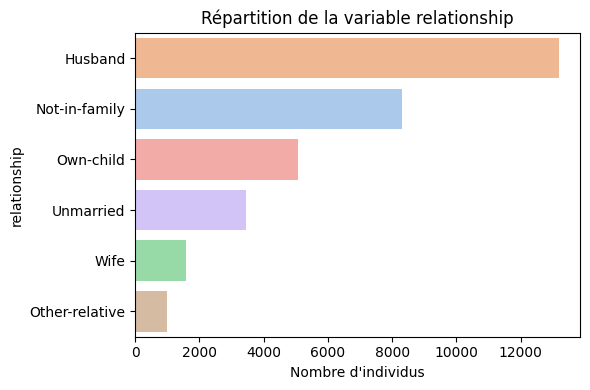

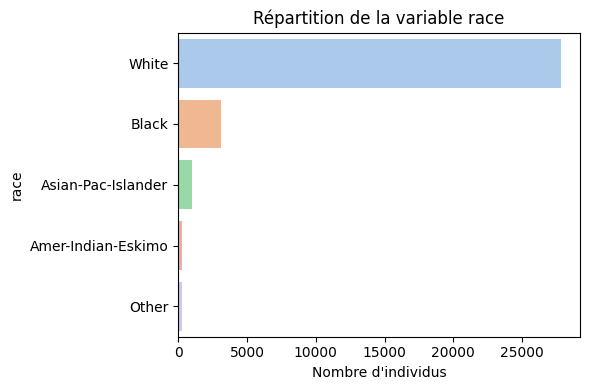

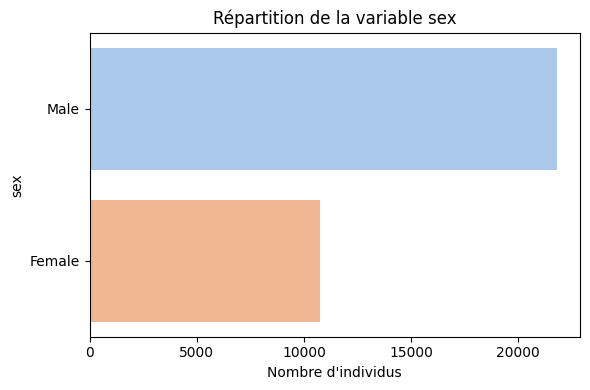

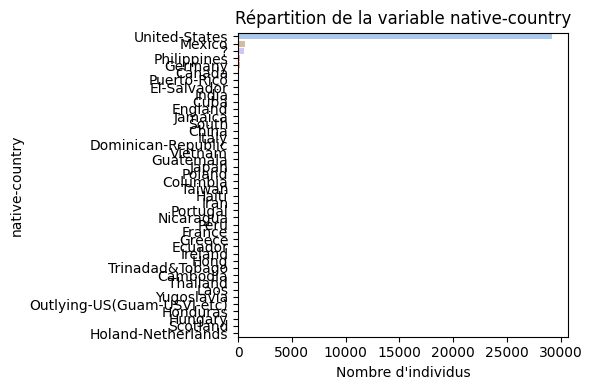

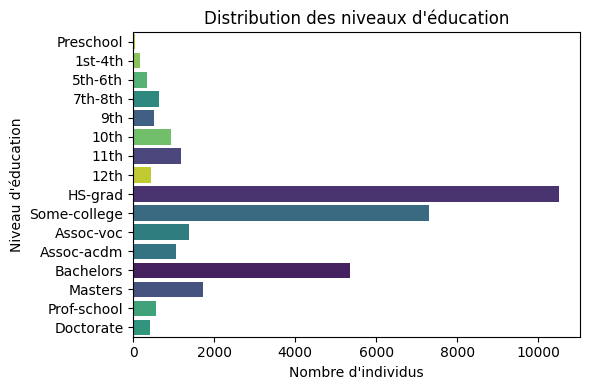


Correspondance entre education et education-num :
        education  education-num
224     Preschool              1
160       1st-4th              2
56        5th-6th              3
15        7th-8th              4
6             9th              5
77           10th              6
3            11th              7
415          12th              8
2         HS-grad              9
10   Some-college             10
14      Assoc-voc             11
13     Assoc-acdm             12
0       Bachelors             13
5         Masters             14
52    Prof-school             15
20      Doctorate             16


In [82]:
# Liste des variables catégorielles
categorical_features = ['workclass', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country', 'education']

#Tableau de comptage pour chaque variable
# for col in categorical_features:
#     print(f"\nVariable: {col}")
#     print(adult[col].value_counts())

# Barplots
for col in categorical_features:
    plt.figure(figsize=(6,4))
    
    if col == 'education':
        # Trier par education-num pour un ordre logique
        edu_order = adult[['education', 'education-num']].drop_duplicates().sort_values('education-num')['education'] 
        sns.countplot(y=col, data=adult, order=edu_order, palette='viridis', hue=col, legend=False)
        plt.title("Distribution des niveaux d'éducation")
        plt.xlabel("Nombre d'individus")
        plt.ylabel("Niveau d'éducation")
    else:
        # Trier par fréquence décroissante pour les autres variables
        order = adult[col].value_counts().index
        sns.countplot(y=col, data=adult, order=order, palette='pastel', hue=col, legend=False)
        plt.title(f"Répartition de la variable {col}")
        plt.xlabel("Nombre d'individus")
        plt.ylabel(col)
    
    plt.tight_layout()
    plt.show()

#Table pour education + education-num
education_mapping = adult[['education', 'education-num']].drop_duplicates().sort_values('education-num')
print("\nCorrespondance entre education et education-num :")
print(education_mapping)


__*Native-country*__

La grande majorité des individus viennent des Etats-Unis, et beaucoup de pays sont très peu représentés. Le modèle risque de leur attribuer trop peu de poids ou de mal les interpréter. Pour mieux exploiter cette information il serait préférable dans la partie __2.__ de regrouper les pays en zones géographiques.

In [83]:
adult_south = adult[adult['native-country']=='South']

print("Nombre d'idividus ayant comme attribut 'South' pour la feature 'native-country' : ", adult_south.shape[0])


Nombre d'idividus ayant comme attribut 'South' pour la feature 'native-country' :  80


80 individus sont associés à un pays d'origine non attribué : 'South'. Cela peut-être dû à une erreur typographique. Il faudrait mieux supprimer ces individus plutôt que de les attribuer de manière arbitraire à une zone géographique.

__*Workclass*__

Nous pouvons remarquer que pour la feature 'workclass', il existe une catégorie particulière : 'Never-worked'. Regardons de plus près cette catégorie pour voir si il serait pertinent de simplifier le dataset.

In [84]:
### Catégorie "Never-worked"

# Sélection des individus avec workclass = 'Never-worked'
never_worked_occupations = adult.loc[adult['workclass'] == 'Never-worked', 'occupation']

# Afficher les valeurs uniques
print("Professions exercées par les individus dont le type d'emploi est 'Never-worked' : ")
print(never_worked_occupations.unique())

num_never_worked = (adult['workclass'] == 'Never-worked').sum()
print("\nNombre d'individus dont le type d'emploi est 'Never-worked' :", num_never_worked)



Professions exercées par les individus dont le type d'emploi est 'Never-worked' : 
['?']

Nombre d'individus dont le type d'emploi est 'Never-worked' : 7


Les individus dont le type d'emploi est 'Never-worked' représentent une part marginale de l'échantillon, et n'ont pas de catégorie de profession associée. Nous pouvons supprimer ces individus pour les parties suivantes de l'étude car ils n'apportent pas d'information utile pour la prédiction de income.

<span style='color:skyblue'>

#### 1.2.3 Variable cible : __*income*__

Le dataset est déséquilibré au niveau de la variable cible : 76% des individus gagnent un salaire inférieur ou égal à 50K.

income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


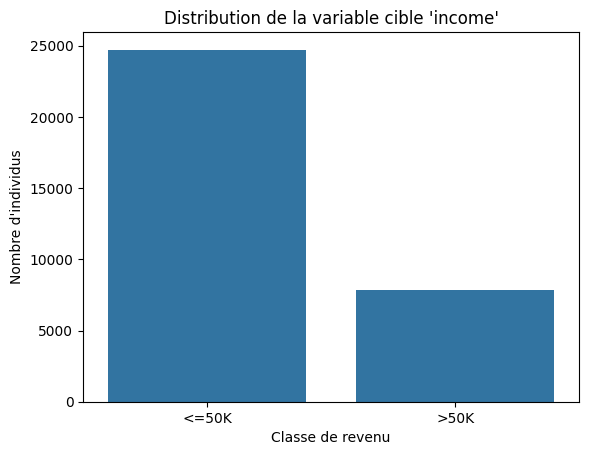

In [86]:
# Proportion de chaque classe
proportions = adult['income'].value_counts(normalize=True) * 100
print(proportions)

sns.countplot(x='income', data=adult)
plt.title("Distribution de la variable cible 'income'")
plt.xlabel("Classe de revenu")
plt.ylabel("Nombre d'individus")
plt.show()

<span style='color:skyblue'>

#### 1.2.4 Valeurs manquantes 

Nous avons remarqué en explorant les données catégorielles que pour certaines variables les catégories n'étaient pas renseignées (cf présence de '?'). Nous allons donc regarder les données manquantes par feature.


Nombre de lignes avec au moins un '?' : 2399
Proportion de lignes avec au moins un '?' : 7.367709836921471 %


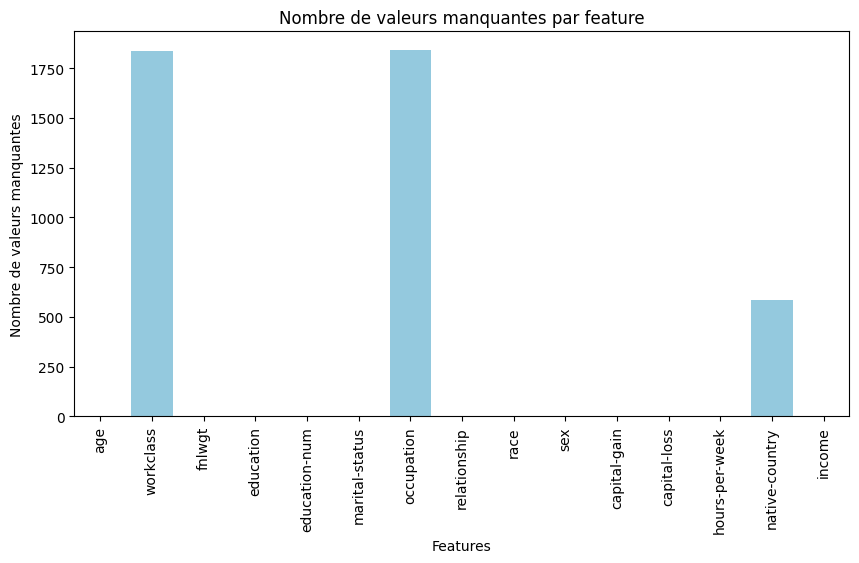

In [87]:
# Compter les lignes avec au moins un '?'
adult.replace("?", np.nan, inplace=True)  # Remplacer '?' par NaN pour faciliter le comptage
num_missing_rows = adult.isna().any(axis=1).sum()

print("Nombre de lignes avec au moins un '?' :", num_missing_rows)
print("Proportion de lignes avec au moins un '?' :", num_missing_rows/adult.shape[0] * 100, '%')


# Compter le nombre de '?' par colonne
missing_counts = adult.isna().sum()

plt.figure(figsize=(10,5))
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='skyblue')
plt.xticks(rotation=90)
plt.title("Nombre de valeurs manquantes par feature")
plt.xlabel("Features")
plt.ylabel("Nombre de valeurs manquantes")
plt.show()


Seules trois variables catégorielles présentent des données manquantes. Ces données concernant 7% des individus du dataset. 

Pour chaque variable workclass, occupation, native-country, nous allons regarder la part que representent les données non renseignées parmi les autres catégories.

In [88]:
cols_with_missing = ['workclass', 'occupation', 'native-country']

for col in cols_with_missing:
    counts = adult[col].value_counts()
    total = counts.sum()

    na = adult[col].isna().sum()

    print(f"Proportion de valeurs manquantes dans la colonne '{col}': {na/total * 100:.2f}%")

Proportion de valeurs manquantes dans la colonne 'workclass': 5.98%
Proportion de valeurs manquantes dans la colonne 'occupation': 6.00%
Proportion de valeurs manquantes dans la colonne 'native-country': 1.82%


Pour chaque feature, la part des données non renseignées est non négigeable. La part des valeurs manquantes est de :
- __5.6%__ dans __*workclass*__ , 4ème catégorie parmi les 9 ;
- __5.7%__ dans __*occupation*__ , 8ème catégorie parmi les 15 ;
- __1.8%__ dans __*native-country*__ , 3ème catégorie parmi les 42 ;

On va maintenant chercher à trouver des patterns dans les valeurs manquantes. Par exemple le nombre de valeurs manquantes de workclass et de occupation semblent assez proches...

In [89]:
pd.crosstab(adult["workclass"].isna(), adult["occupation"].isna(), normalize="index")

occupation,False,True
workclass,,
False,0.999772,0.000228
True,0.000000,1.000000


<span style='color:skyblue'>

### 1.3 Conclusion sur l'exploration des données

</span>

__Features numériques :__

- Rôle de la feature __*fnlwgt*__ :  

Pour rappel, chaque individu du dataset représente un certain nombre de personnes réelles dans la population US et *fnlwgt* indique ce poids.
Si l'objectif est d'utiliser des méthodes de statistique descriptive pour réaliser des analyses représentatives de la population US, il faudrait prendre cette feature en compte pour pondérer les individus. 
Or, l'objectif ici est de prédire la variable *income* à partir des autres features. Donc ne pas se servir de *fnlwgt* n'empêche pas le modèle d'apprendre les relations entre les features et la cible à partir de l'échantillon. Il faudrait donc la supprimer du dataset en tant que feature car elle n'a pas de sens "physique" pour la caractérisation d'un individu.

Dans la partie 3. nous nous servirons de cette donnée en tant que poids optionnels dans nos algorithmes d'apprentissage, afin d'entrainer le modèle soit sur les individus présents sur le dataset, soit sur la population US entière.


__Features catégorielles :__

- __*Native-country*__ : Il faudra regrouper les 40 pays catégorisés en zones géographiques, et supprimer les individus avec un pays d'origine non identifié.

- __*Workclass*__ : Suppression des individus dont le type d'emploi est 'Never-worked' pour simplifier le dataset. (voir *1.2.2 Variables catégorielles*)

__Target :__

- Déséquilibre sur la variable cible __*income*__ : 

Le dataset représente beaucoup plus d'individus gagnant <=50K, ce qui pourrait influencer les modèles qui auront tendance à prédire la classe majoritaire.
Nous tenterons d'utiliser les poids contenus dans la colonne *fnlwgt* pour corriger ce biais.


__Gestion des valeurs manquantes :__

Les valeurs manquantes sont majoritairement liées à un manque d'information sur l'emploi des individus (features *workclass* et *occupation*). Nous allons donc écartes les lignes présentant au moins une valeur manquante.



<span style='color:skyblue'>

## 2. Préparation et transformation des données - feature engineering phase



Grâce à l'étape d'exploration des données réalisée dans la partie 1., nous avons pu identifier les actions nécessaires à réaliser sur les données avant de mettre en place des modèles. 
En particulier, nous aimerions supprimer les *valeurs manquantes*, les données peu informatives ainsi que les *outliers*. De plus, l'encodage des features catégorielles sous forme de texte pose problème pour la mise en place de nos algorithmes. C'est la raison pour laquelle nous allons mettre en place cette pipeline de nettoyage :
- **Suppression des données peu informatives :**  Suppression des lignes avec des '?' et des colonnes non nécessaires 
Nous avons également décidé d'enlever la colonne race pour ne pas introduire et reproduire ces biais non souhaitables dans nos algorithmes.
Nous avons également simplifié les attributs de la colonne *native-country* pour regrouper les pays d'origines en zones géographiques.
Nous avons supprimé la colonne *education* car l'information portée par celle-ci est déjà contenue dans la colonne 'education-num'
Nous avons supprimé les individus dont le pays d'origine est non identifié.
- **Encodage des colonnes :** Nous allons encoder chaque feature catégorielle de la façon suivante : chaque valeur unique se voit attribuer un entier. 
- **Normalisation :** Pour contrer l'effet du nombre de colonnes, nous allons normaliser celles ci
- **Gestion des outliers**



<span style='color:skyblue'>

### 2.1 Suppression des données non utiles 

</span>

In [90]:
#### Suppression des données non utiles pour la suite de l'étude 
# --- 1. suppression des individus comportant des données non renseignées (notées '?') 
# --- 2. suppression de la colonne 'race' 
# --- 3. suppression de la colonne 'education', car la colonne 'education-num contient déjà l'information
# --- 4. suppression des individus dont le pays d'origine est non identifié

def clean(adult):

    adult_cleaned = adult.copy()

    adult_cleaned.replace("?", pd.NA, inplace=True)  # Les NA sont codés par des "?"

    for key in adult_cleaned.keys():
        n_na = adult_cleaned[key].isna().sum()
        if n_na > 0:
            print(f"{key} : {n_na} NA")

    adult_cleaned.dropna(inplace=True)  # On supprime les lignes avec NA (1)

    adult_cleaned.drop(columns=["race", "education"], inplace=True)  # On enlève les colonne races et education (2) et (3)

    adult_cleaned = adult_cleaned[adult_cleaned['native-country'] != 'South'] # Suppression des individus dont le pays d'origine est 'South' (4)


    return adult_cleaned

<span style='color:skyblue'>

### 2.2 Transformation des données 

</span>

Simplication des attributs de la colonne 'native-country' qui sera renommée 'region'

In [91]:
#### Transformation de la colonne 'native-country' ####

def simplify_country(country):
    if pd.isna(country):
        return 'Other'
    
    # US
    if country == 'United-States':
        return 'US'

    # Latin America
    latin_america = [
        'Mexico', 'Cuba', 'Jamaica', 'Puerto-Rico', 'Trinadad&Tobago', 
        'Honduras', 'El-Salvador', 'Guatemala', 'Nicaragua', 'Haiti', 
        'Dominican-Republic', 'Columbia', 'Ecuador', 'Peru'
    ]
    if country in latin_america:
        return 'Latin America'

    # North America (hors US)
    north_america = ['Canada', 'Outlying-US(Guam-USVI-etc)']
    if country in north_america:
        return 'North America'

    # Europe
    europe = [
        'England', 'Germany', 'Italy', 'Poland', 'Portugal', 'France', 
        'Yugoslavia', 'Scotland', 'Greece', 'Ireland', 'Hungary', 'Holand-Netherlands'
    ]
    if country in europe:
        return 'Europe'

    # Asia / Oceania
    asia_oceania = ['India', 'Iran', 'Philippines', 'Cambodia', 'Thailand', 
                    'Laos', 'Taiwan', 'Japan', 'Vietnam', 'Hong', 'China']
    if country in asia_oceania:
        return 'Asia/Oceania'

    # Autres ou inconnus
    print(country)
    return 'Other'

def transform_native_country(adult):

    adult_native_country_transformed = adult.copy()

    adult_native_country_transformed['region'] = adult_native_country_transformed['native-country'].apply(simplify_country)
    adult_native_country_transformed.drop(columns=['native-country'], inplace=True)

    return adult_native_country_transformed

<span style='color:skyblue'>

### 2.3 Encodage des données

In [92]:
#### Encodage des colonnes ####
from sklearn.preprocessing import LabelEncoder

def encode(adult):
    # Colonnes considérées comme numériques
    numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    adult_encoded = adult.copy()

    label_encoders = {}

    # Sélectionner seulement les colonnes non numériques hors numerical_features
    categorical_features = [
        col for col in adult_encoded.columns 
        if col not in numerical_features and adult_encoded[col].dtype == 'object'
    ]

    # Vérifier la présence de '?' dans les colonnes catégorielles
    if (adult_encoded[categorical_features] == '?').any().any():
        raise ValueError("Le dataset contient des '?' dans les colonnes catégorielles !")

    # Encoder chaque colonne catégorielle
    for column in categorical_features:
        le = LabelEncoder()
        adult_encoded[column] = le.fit_transform(adult_encoded[column])
        label_encoders[column] = le

    return adult_encoded, label_encoders


<span style='color:skyblue'>

### 2.4 Normalisation 

In [93]:
#### Normalisation ####
from sklearn.preprocessing import StandardScaler

def normalize(adult):

    adult_normalized = adult.copy()
    scaler = StandardScaler()

    for column in adult_normalized.columns:
        if column != "income" and column != "fnlwgt":  # On ne normalise pas la target
            adult_normalized[[column]] = scaler.fit_transform(adult_normalized[[column]])

    return adult_normalized

    

<span style='color:skyblue'>

### 2.5 Gestion des outliers 

In [94]:
from sklearn.ensemble import IsolationForest

def remove_outliers(adult):

    adult_without_outliers = adult.copy()

    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(adult_without_outliers.drop(columns=["income"]))
    mask = outliers != -1
    return adult_without_outliers[mask]



<span style='color:skyblue'>

### 2.6 Conclusion : nettoyage et pré-processing

In [95]:
print("--- Dataset brut --- ")
print(f"Nombre de lignes : ", adult.shape[0])


print(" \n--- Nettoyage --- ")
adult_cleaned = clean(adult)
print("Nombre de lignes après suppression des '?': ", adult_cleaned.shape[0])

print(" \n--- Transformation feature 'native-country --- ")
adult_transform_native_country = transform_native_country(adult_cleaned)
print("Zones géographiques : ", adult_transform_native_country['region'].unique())


print(" \n--- Encodage des features catégorielles --- ")
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'region']
adult_encoded, label_encoders = encode(adult_transform_native_country)
print(adult_encoded[categorical_features].head())


print(" \n--- Normalisation des données --- ")
adult_normalized = normalize(adult_encoded)
print(adult_normalized.head())


print(" \n--- Gestion des outliers --- ")
adult_sans_outliers = remove_outliers(adult_normalized)
print(f"Nombre de lignes après suppression des outliers : {adult_sans_outliers.shape[0]}")

--- Dataset brut --- 
Nombre de lignes :  32561
 
--- Nettoyage --- 
workclass : 1836 NA
occupation : 1843 NA
native-country : 583 NA
Nombre de lignes après suppression des '?':  30091
 
--- Transformation feature 'native-country --- 
Zones géographiques :  ['US' 'Latin America' 'Asia/Oceania' 'Europe' 'North America']
 
--- Encodage des features catégorielles --- 
   workclass  marital-status  occupation  relationship  sex  region
0          5               4           0             1    1       4
1          4               2           3             0    1       4
2          2               0           5             1    1       4
3          2               2           5             0    1       4
4          2               2           9             5    0       2
 
--- Normalisation des données --- 
        age  workclass  fnlwgt  education-num  marital-status  occupation  \
0  0.042888   2.937682   77516       1.129698        0.948067   -1.478440   
1  0.880363   1.889147   83311   

<span style='color:skyblue'>

## 3. Apprentissage des modèles - learning phase

Pour la phase d'apprentissage nous allons entraîner un classifieur, la target *income* étant encodée sur 2 valeurs. Pour *tester ce que ça donne* nous allons regarder si introduire les poids dans l'entraînement change quelque chose aux performance du modèle.

On choisit deux modèles pour l'instant, RandomForest et XGB, puis nous concluerons sur les performances de chacun pour passer en phase 4 et 5

<span style='color:skyblue'>

### 3.1 RandomForest

__*Nettoyage et préprocessing*__

Pour utiliser RandomForest, il suffit d'encoder les features catégorielles pour leur attribuer un entier. Il n'est pas nécessaire de normaliser la donnée car l'algorithme décide des splits selon des seuils de valeur.

In [96]:
adult_cleaned = clean(adult)
adult_transform_native_country = transform_native_country(adult_cleaned)
adult_encoded, label_encoders = encode(adult_transform_native_country)

adult_final_rf = adult_encoded.copy()

workclass : 1836 NA
occupation : 1843 NA
native-country : 583 NA


__*Algorithme RandomForest :*__

In [97]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold  

def random_forest(adult, WEIGHTING, N_FOLDS, REMOVE_OUTLIERS, N_ESTIMATORS, verbose = False):
    adult_rf = adult.copy()
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    if REMOVE_OUTLIERS:
        adult_rf = remove_outliers(adult_rf)
        
    X = adult_rf.drop(columns=["income", "fnlwgt"])
    y = adult_rf["income"]
    weights = adult_rf["fnlwgt"]

    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index].copy()
        X_test = X.iloc[test_index].copy()
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # on enlève toujours fnlwgt des features
        X_train.drop(columns=["fnlwgt"], inplace=True, errors="ignore")
        X_test.drop(columns=["fnlwgt"], inplace=True, errors="ignore")

        # nouveau modèle à chaque fold
        clf = RandomForestClassifier(
            n_estimators=N_ESTIMATORS,
            random_state=42,
            n_jobs=-1
        )

        if WEIGHTING:
            train_weights = weights.iloc[train_index].astype(float)
            # petite normalisation pour éviter les valeurs trop grandes
            train_weights = train_weights / train_weights.mean()
            clf.fit(X_train, y_train, sample_weight=train_weights)
        else:
            clf.fit(X_train, y_train)

        # prédiction + accuracy
        accuracy = accuracy_score(y_test, clf.predict(X_test))
        precision = precision_score(y_test, clf.predict(X_test))
        recall = recall_score(y_test, clf.predict(X_test))
        f1 = f1_score(y_test, clf.predict(X_test))
        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1s.append(f1)

    # Calcul de la moyenne
    mean_acc = np.mean(fold_accuracies)
    mean_prec = np.mean(fold_precisions)
    mean_rec = np.mean(fold_recalls)
    mean_f1 = np.mean(fold_f1s)

    # Importance des features
    importances = clf.feature_importances_
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    if verbose:
        print("Random Forest accuracy:", mean_acc)
        print("Random Forest precision:", mean_prec)
        print("Random Forest recall:", mean_rec)
        print("Random Forest F1-score:", mean_f1)

        print("\nTop 10 des features les plus importantes :")
        print(feature_importance.head(10))

    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s, feature_importance

In [98]:
WEIGHTING = False
N_FOLDS = 5
OUTLIER_REMOVAL = True
N_ESTIMATORS = 200

acc, prec, rec, f1, feature_imp = random_forest(adult=adult_final_rf, WEIGHTING=WEIGHTING, N_FOLDS=N_FOLDS, REMOVE_OUTLIERS=OUTLIER_REMOVAL, N_ESTIMATORS=N_ESTIMATORS, verbose=True)



Random Forest accuracy: 0.8427903181805363
Random Forest precision: 0.7011349821105567
Random Forest recall: 0.6103652856119217
Random Forest F1-score: 0.6525350491036588

Top 10 des features les plus importantes :
           Feature  Importance
0              age    0.230144
2    education-num    0.143039
9   hours-per-week    0.113889
7     capital-gain    0.113704
5     relationship    0.109520
4       occupation    0.092245
3   marital-status    0.083814
1        workclass    0.052237
8     capital-loss    0.034039
10          region    0.013806


<span style='color:skyblue'>

### 3.2 XGB

__*Nettoyage et préprocessing*__

Pour la même raison que le random forest, il suffit d'encoder les variables, nous n'avons pas besoin de les normaliser pour implémenter XGBoost

In [99]:
adult_cleaned = clean(adult)
adult_transform_native_country = transform_native_country(adult_cleaned)
adult_encoded, label_encoders = encode(adult_transform_native_country)

adult_final_xgb = adult_encoded.copy()

workclass : 1836 NA
occupation : 1843 NA
native-country : 583 NA


__*Algorithme XGBoost :*__

In [113]:
def xgboost(params, adult, WEIGHTING, N_FOLDS, REMOVE_OUTLIERS, num_boost_round=100, verbose=False):
    adult_xgb = adult.copy()
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    if REMOVE_OUTLIERS:
        adult_xgb = remove_outliers(adult_xgb)
    X = adult_xgb.drop(columns=["income", "fnlwgt"])
    y = adult_xgb["income"]
    weights = adult_xgb["fnlwgt"]

    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index].copy()
        X_test = X.iloc[test_index].copy()
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]    
        
        if WEIGHTING:
            X_train.drop(columns=["fnlwgt"], inplace=True, errors='ignore')
            X_test.drop(columns=["fnlwgt"], inplace=True, errors='ignore')
            train_weights = weights.iloc[train_index]
            dtrain = xgb.DMatrix(X_train, label=y_train, weight=train_weights)
            dtest = xgb.DMatrix(X_test, label=y_test)
        else:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)

        bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

        preds = bst.predict(dtest)
        predictions = [1 if pred > 0.5 else 0 for pred in preds]
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)

        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1s.append(f1)

    importance = bst.get_score(importance_type='weight')
    importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

    if verbose:
        print("XGBoost accuracy:", np.mean(fold_accuracies))
        print("XGBoost precision:", np.mean(fold_precisions))
        print("XGBoost recall:", np.mean(fold_recalls))
        print("XGBoost F1-score:", np.mean(fold_f1s))

    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s, importance_df

<span style='color:skyblue'>

## 4. Optimisation des modèles - Hyperparameter tuning phase

</span>

Dans cette partie, nous avons optimisé les hyperparamètres de deux classifieurs : Random Forest (RFG) et XGBoost, appliqués au jeu de données Adult de l’UCI Machine Learning Repository.
L’objectif est d’améliorer leurs performances en ajustant les paramètres clés (comme la profondeur des arbres, le nombre d’estimateurs ou le taux d’apprentissage).

L’évaluation des modèles s’appuie sur plusieurs métriques :

- Accuracy : taux global de bonnes prédictions,

- Precision : proportion de prédictions positives correctes,

- Recall : capacité à détecter les vrais positifs,

- F1-score : compromis entre précision et rappel.

Ces mesures permettent de comparer les performances des modèles avant et après l’optimisation pour esnuite choisir un modèle adapté à la problématique. Certains de ces scores sont un peu redondants, surtout le F1, mais on s'en sert à différent moment.

<span style='color:skyblue'>

### 4.1 Weighting et outliers test

</span>
A partir de deux modèles non fine-tuné nous allons chercher à savoir si notre méthode de suppression des outliers permet d'améliorer les performances, et si ajouter les poids influence les performances. Bien qu'il ne s'agisse pas d'hyperparamètres nous le faisons ici.

In [117]:
# Grille de recherche pour WEIGHTING et OUTLIER_REMOVAL
weighting_values = [True, False]
outlier_removal_values = [True, False]
N_FOLDS = 5

# Définition des paramètres par défaut
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}
num_boost_round = 100

#Boucle de recherche
for weighting in weighting_values:
    for outlier_removal in outlier_removal_values:
        print(f"\nTesting with WEIGHTING={weighting}, OUTLIER_REMOVAL={outlier_removal}")
        acc_xgb, prec_xgb, rec_xgb, f1_xgb, imp_xgb = xgboost(params=params, num_boost_round=num_boost_round, adult=adult_final_rf, WEIGHTING=weighting, N_FOLDS=N_FOLDS, REMOVE_OUTLIERS=outlier_removal)
        print("XGBoost results: Accuracy =", np.mean(acc_xgb))
        acc_rf, prec_rf, rec_rf, f1_rf, imp_rf = random_forest(adult=adult_final_rf, WEIGHTING=weighting, N_FOLDS=N_FOLDS, REMOVE_OUTLIERS=outlier_removal, N_ESTIMATORS=N_ESTIMATORS)
        print("Random Forest results: Accuracy =", np.mean(acc_rf))

# Affichage du denier (le meilleur)
print(imp_xgb)
print(imp_rf)


Testing with WEIGHTING=True, OUTLIER_REMOVAL=True
XGBoost results: Accuracy = 0.862030511897195
Random Forest results: Accuracy = 0.8421256155512211

Testing with WEIGHTING=True, OUTLIER_REMOVAL=False
XGBoost results: Accuracy = 0.8657738917047386
Random Forest results: Accuracy = 0.8442722670996812

Testing with WEIGHTING=False, OUTLIER_REMOVAL=True
XGBoost results: Accuracy = 0.8668929941034218
Random Forest results: Accuracy = 0.8427903181805363

Testing with WEIGHTING=False, OUTLIER_REMOVAL=False
XGBoost results: Accuracy = 0.8703598789940198
Random Forest results: Accuracy = 0.8458342257383578
           Feature  Importance
0              age       694.0
9   hours-per-week       507.0
4       occupation       357.0
2    education-num       347.0
7     capital-gain       273.0
8     capital-loss       220.0
1        workclass       192.0
5     relationship       152.0
3   marital-status       145.0
10          region        67.0
6              sex        48.0
           Feature  I

A priori on constate que le meilleur modèle en terme d'accuracy et de précision est le XGBoost, sans utilisation des poids ni de la méthode de suppression des outliers. On va donc conserver celui ci.

__Définir les hyperparamètres à évaluer__

### XGBoost
- **`n_estimators`** : nombre total d’arbres construits.  
- **`learning_rate`** : taux d’apprentissage contrôlant la contribution de chaque arbre.  
- **`max_depth`** : profondeur maximale des arbres.  
- **`gamma`** : réduction minimale de perte requise pour un split.  

Testing with eta=0.01, max_depth=1
Testing with eta=0.01, max_depth=3
Testing with eta=0.01, max_depth=5
Testing with eta=0.01, max_depth=7
Testing with eta=0.01, max_depth=15
Testing with eta=0.1, max_depth=1
Testing with eta=0.1, max_depth=3
Testing with eta=0.1, max_depth=5
Testing with eta=0.1, max_depth=7
Testing with eta=0.1, max_depth=15
Testing with eta=0.2, max_depth=1
Testing with eta=0.2, max_depth=3
Testing with eta=0.2, max_depth=5
Testing with eta=0.2, max_depth=7
Testing with eta=0.2, max_depth=15
Testing with eta=0.3, max_depth=1
Testing with eta=0.3, max_depth=3
Testing with eta=0.3, max_depth=5
Testing with eta=0.3, max_depth=7
Testing with eta=0.3, max_depth=15
Testing with eta=0.5, max_depth=1
Testing with eta=0.5, max_depth=3
Testing with eta=0.5, max_depth=5
Testing with eta=0.5, max_depth=7
Testing with eta=0.5, max_depth=15
Testing with eta=1, max_depth=1
Testing with eta=1, max_depth=3
Testing with eta=1, max_depth=5
Testing with eta=1, max_depth=7
Testing with

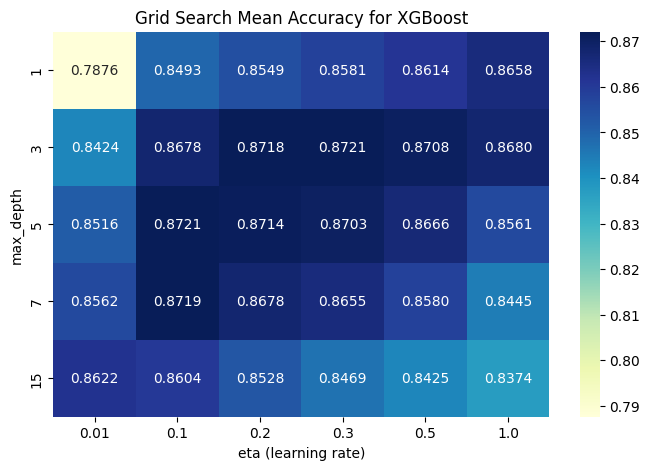

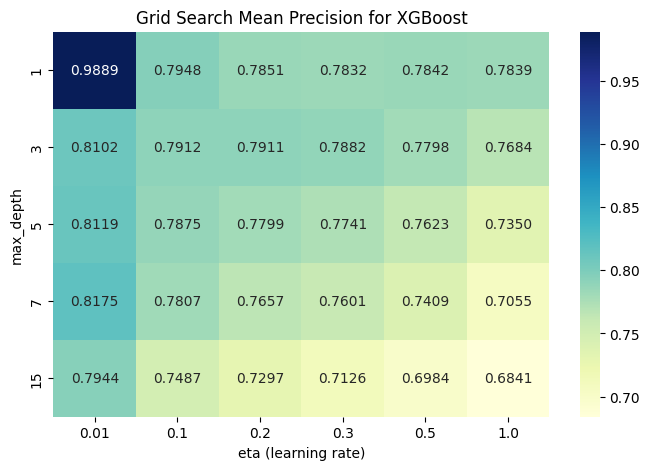

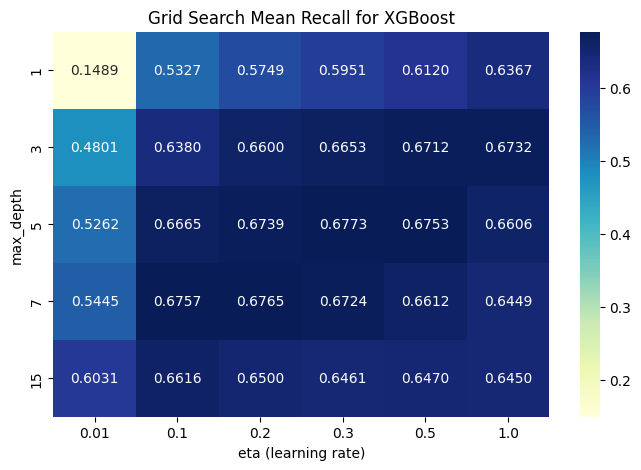

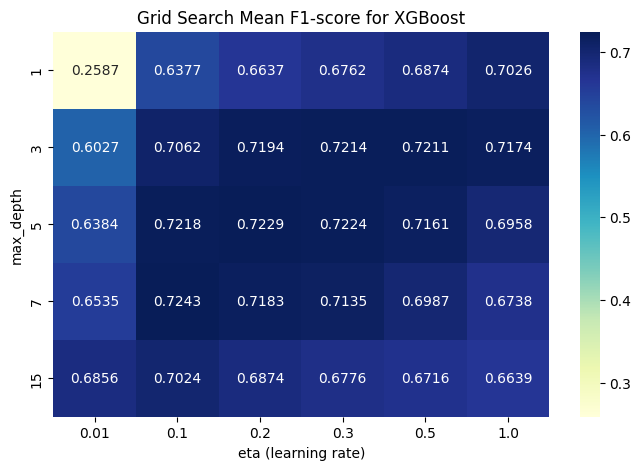

In [103]:
param = {'eta': 0.3, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42}

grid_search = {
    "eta": [0.01, 0.1, 0.2, 0.3, 0.5, 1],
    "max_depth": [1, 3, 5, 7, 15],
}

grid_results = []

for eta in grid_search["eta"]:
    for max_depth in grid_search["max_depth"]:
        params = {
            'eta': eta,
            'max_depth': max_depth,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'seed': 42
        }
        print(f"Testing with eta={eta}, max_depth={max_depth}")
        accuracy_scores, precision_scores, recall_scores, f1_scores, feature_importance = xgboost(params=params, adult=adult_normalized, WEIGHTING=False, N_FOLDS=N_FOLDS, REMOVE_OUTLIERS=False)
        mean_accuracy = np.mean(accuracy_scores)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)
        grid_results.append({
            "eta": eta,
            "max_depth": max_depth,
            "mean_accuracy": mean_accuracy,
            "mean_precision": mean_precision,
            "mean_recall": mean_recall,
            "mean_f1": mean_f1
        })

# Affichage des résultats
df_results = pd.DataFrame(grid_results)
pivot_acc = df_results.pivot(index="max_depth", columns="eta", values="mean_accuracy")
pivot_prec = df_results.pivot(index="max_depth", columns="eta", values="mean_precision")
pivot_rec = df_results.pivot(index="max_depth", columns="eta", values="mean_recall")
pivot_f1 = df_results.pivot(index="max_depth", columns="eta", values="mean_f1")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_acc, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Grid Search Mean Accuracy for XGBoost")
plt.xlabel("eta (learning rate)")
plt.ylabel("max_depth")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_prec, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Grid Search Mean Precision for XGBoost")
plt.xlabel("eta (learning rate)")
plt.ylabel("max_depth")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_rec, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Grid Search Mean Recall for XGBoost")
plt.xlabel("eta (learning rate)")
plt.ylabel("max_depth")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_f1, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Grid Search Mean F1-score for XGBoost")
plt.xlabel("eta (learning rate)")
plt.ylabel("max_depth")
plt.show()


Il nous est difficile de conclure sur un choix d'hyper paramètres sans connaître la finalité de l'utilisation du modèle (pour déterminer quel compromis nous convient). Ainsi dans un but d'avoir un modèle polyvalent on se propoe de prendre un learning rate de 0.2 et une max depth de 3

XGBoost accuracy: 0.871822087042301
XGBoost precision: 0.7910939020512667
XGBoost recall: 0.6599997182198079
XGBoost F1-score: 0.7194173852254157


/tmp/ipykernel_4466/3169889149.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_imp, palette="viridis")


Text(0, 0.5, 'Feature')

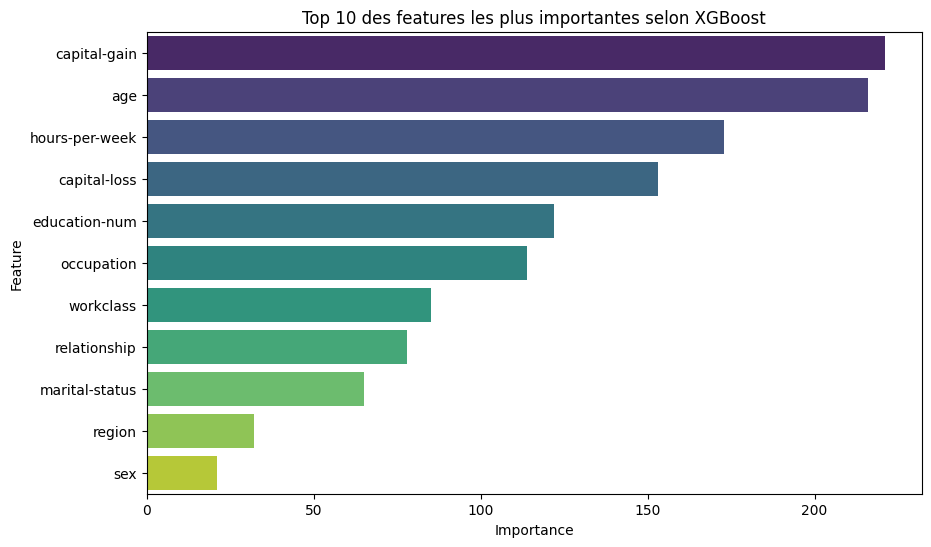

In [109]:
lr = 0.2
max_depth = 3

params = {
    'eta': lr,
    'max_depth': max_depth,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

feature_imp = xgboost(params=params, adult=adult_final_xgb, WEIGHTING=False, N_FOLDS=5, REMOVE_OUTLIERS=False, verbose=True)[4]

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_imp, palette="viridis")
plt.title("Top 10 des features les plus importantes selon XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")

Testing with num_boost_round=1


/home/alexandre-tonon/anaconda3/envs/sdd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alexandre-tonon/anaconda3/envs/sdd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alexandre-tonon/anaconda3/envs/sdd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Testing with num_boost_round=5
Testing with num_boost_round=10
Testing with num_boost_round=50
Testing with num_boost_round=100
Testing with num_boost_round=200
Testing with num_boost_round=300
Testing with num_boost_round=500
Testing with num_boost_round=1000
Testing with num_boost_round=5000


Text(0.5, 1.0, 'Performance de XGBoost en fonction du nombre de rounds')

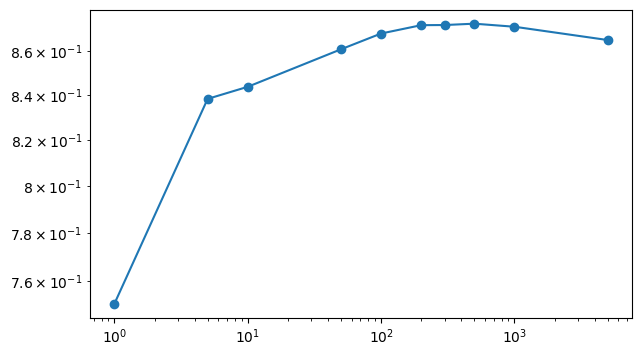

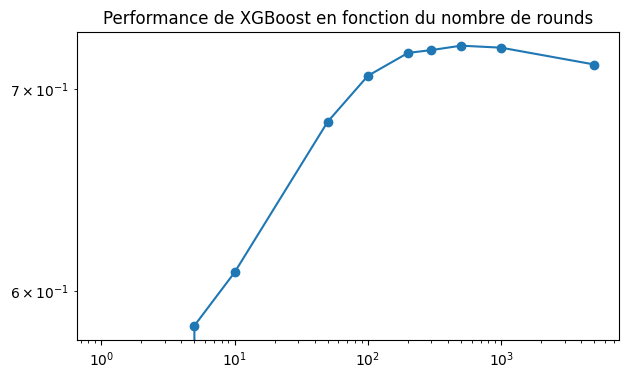

In [116]:
num_boost_round_list = [1, 5, 10, 50, 100, 200, 300, 500, 1000, 5000]
results_boost_round = []

for num_boost_round in num_boost_round_list:
    print(f"Testing with num_boost_round={num_boost_round}")
    acc_xgb, prec_xgb, rec_xgb, f1_xgb, imp_xgb = xgboost(params=params, num_boost_round=num_boost_round, adult=adult_final_rf, WEIGHTING=False, N_FOLDS=N_FOLDS, REMOVE_OUTLIERS=False)
    results_boost_round.append({
        "num_boost_round": num_boost_round,
        "accuracy": np.mean(acc_xgb),
        "precision": np.mean(prec_xgb),
        "recall": np.mean(rec_xgb),
        "f1_score": np.mean(f1_xgb)
    })
df_boost_round = pd.DataFrame(results_boost_round)
plt.figure(figsize=(7,4))
plt.xscale('log')
plt.yscale('log')
plt.plot(df_boost_round["num_boost_round"], df_boost_round["accuracy"], marker='o', label='Accuracy')

plt.figure(figsize=(7,4))
plt.plot(df_boost_round["num_boost_round"], df_boost_round["f1_score"], marker='o', label='F1-score')
plt.xscale('log')
plt.yscale('log')
plt.title("Performance de XGBoost en fonction du nombre de rounds")

<span style='color:skyblue'>

## 5. “Analyse et perspectives” - Conclusion phase

Ca depend du problème, exemple de détection de fraude

compromis biais variance ou taux de recall
